# A simple hydrological model

This is a tutorial programming basic hydrological rainfall runoff (bucket) models.

(cc) Ralf Loritz and Conrad Jackisch, KIT 2017

In [1]:
%pylab inline
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid', {'grid.linestyle': u'--'})
matplotlib.rc('pdf', fonttype=42)
figsize(14,5)

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Read hydro data time series
colp = pd.read_csv('Colpach.txt',index_col='date')
colp.index = pd.to_datetime(colp.index)
colp.head(5)

,runoff,precip,temp,rel_hum
date,,,,
2011-01-01 00:00:00,0.058303,0.0,-0.92,100.00
2011-01-01 01:00:00,0.058256,0.0,-0.67,100.00
2011-01-01 02:00:00,0.058067,0.0,-0.55,100.00
2011-01-01 03:00:00,0.057878,0.0,-0.53,100.00
2011-01-01 04:00:00,0.057878,0.0,-0.47,98.67


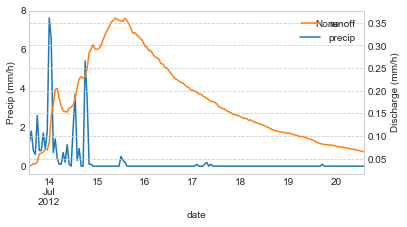

In [3]:
#Select one runoff event manulally
event_begin = pd.to_datetime('2012-07-13 14:00:00')    # manually select event begin from plot
event_end = pd.to_datetime('2012-07-20 14:00:00')     # manually select event end from plot
#event_end1 = pd.to_datetime('2012-07-18 14:00:00')     # manually select event end from plot

#Plot selected event
figsize(6,3)
colp.loc[event_begin:event_end,'precip'].plot()
ylabel('Precip (mm/h)')
legend()
colp.loc[event_begin:event_end,'runoff'].plot(secondary_y=True)
ylabel('Discharge (mm/h)')
legend()

#Sanitise event for modelling
event_precip = colp.loc[event_begin:event_end,'precip'].values
event_runoff = colp.loc[event_begin:event_end,'runoff'].values

#savefig('event_coplac.pdf')

In [4]:
#short aggregated time series for manual calculation
#this is only interesting, with regard to the excercise in the course
#please remember to adjust the residence time decay parameter and ET to 5h aggregates below

#colpa = colp.loc[event_begin:event_end1,['precip','runoff']].resample('5h').sum()#.plot()#.to_latex()

#Sanitise event for modelling
#event_precip = colpa['precip'].values
#event_runoff = colpa['runoff'].values


# Linear Reservoir

A linear reservoir might be the most simple numerical hydrological model. 

Here runoff is simply enerated as fraction of the storage determined by the mean residence time.

In [5]:
#initialisation
l_event = len(event_precip)
storage = np.zeros(l_event+1)
runoff = np.zeros(l_event)

In [6]:
#Parameters
residence_t = 100.  #mean residence time of water in storage (hours)
ET = 0.125          #assumed evapotranspiration around 3mm/day
storage[0] = 2.5    #initial filling of storage

With the parameters above we can calculate the runoff.

Subsequently, the storage is updated based on the water balance.

In [7]:
#Run linear reservoir
for i in np.arange(l_event): #time step loop (1h)
    runoff[i] = storage[i]/residence_t
    storage[i+1] = storage[i] - runoff[i] - ET + event_precip[i]

Text(0.5,1,'Storage')

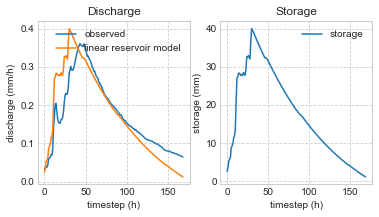

In [8]:
subplot(121)
plot(event_runoff,label='observed')
plot(runoff,label='linear reservoir model')
legend()
xlabel('timestep (h)')
ylabel('discharge (mm/h)')
title('Discharge')

subplot(122)
plot(storage,label='storage')
legend()
xlabel('timestep (h)')
ylabel('storage (mm)')
title('Storage')

#savefig('linstore_result.pdf')

Unfortunately, this ver simple model does not at all perform that convincingly for other events. Thus we may extend our concept a little...

# Beta store

The linear reservoir obviously lacks a soil. This has been addressed in a similarly simple manner with the introduction of a soil storage. Its drainage is controlled by an exponent beta which give the concept its name.

We simply add this to our linear reservoir model to control the subsurface flow.

In [9]:
#initialisation
l_event = len(event_precip)
storage = np.zeros(l_event+1)
runoff = np.zeros(l_event)
soilmoist = np.zeros(l_event+1)
subsurf_flow = np.zeros(l_event)

In [10]:
#Parameters
residence_t = 100  #mean residence time of water in storage (days)
ET = 0.125         #assumed evapotranspiration around 3mm/day
storage[0] = 2.5   #initial filling of storage

beta = 1.25        #beta store exponential parameter
smax = 0.3 * 1000  #Maximum storage as product of soil porosity and soil depth in mm
soilmoist[0] = 150 #Initial soil storage

In [11]:
#Run model
for i in np.arange(l_event): #time step loop (1h)
    #beta store
    subsurf_flow[i] = event_precip[i] * (soilmoist[i]/smax)**beta
    soilmoist[i+1] = soilmoist[i] + event_precip[i] - subsurf_flow[i] - ET
    
    #linear storage
    runoff[i] = storage[i]/residence_t
    storage[i+1] = storage[i] - runoff[i] + subsurf_flow[i]

Text(0.5,1,'Storage')

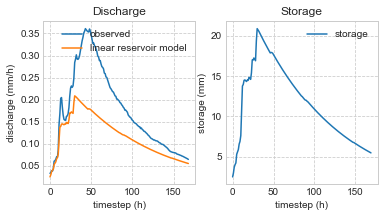

In [12]:
subplot(121)
plot(event_runoff,label='observed')
plot(runoff,label='linear reservoir model')
legend()
xlabel('timestep (h)')
ylabel('discharge (mm/h)')
title('Discharge')

subplot(122)
plot(storage,label='storage')
legend()
xlabel('timestep (h)')
ylabel('storage (mm)')
title('Storage')

# Groundwater store

Groundwater is often accounted for by cascading linear reservoirs. We will do the same and add this to our model.

In [13]:
#initialisation
l_event = len(event_precip)
storage = np.zeros(l_event+1)
runoff = np.zeros(l_event)

soilmoist = np.zeros(l_event+1)
subsurf_flow = np.zeros(l_event)

groundwater_store = np.zeros(l_event+1)  #groundwater storage
groundwater_perc = np.zeros(l_event)     #flow from the upper to the lower bucket of the cascade
groundwater_baseflow = np.zeros(l_event) #flow from groundwater storage

In [14]:
#Parameters
residence_t = 100. #mean residence time of water in storage (days)
ET = 0.125         #assumed evapotranspiration around 3mm/day
storage[0] = 2.5   #initial filling of storage

beta = 1.25        #beta store exponential parameter
smax = 0.3 * 1000  #Maximum storage as product of soil porosity and soil depth in mm
soilmoist[0] = 150 #initial soil storage

groundwater_store[0] = 500  #initial groundwater storage
residence_GW1 = 10000.      #residence time for GW recharge        
residence_GW2 = 100000.     #residence time for GW baseflow

In [15]:
#Run model
for i in np.arange(l_event): #time step loop (1h)
    #beta store
    subsurf_flow[i] = event_precip[i] * (soilmoist[i]/smax)**beta
    soilmoist[i+1] = soilmoist[i] + event_precip[i] - subsurf_flow[i] - ET
    
    #linear storage
    runoff[i] = storage[i]/residence_t
    groundwater_perc[i] = storage[i]/residence_GW1
    storage[i+1] = storage[i] - runoff[i] - groundwater_perc[i] + subsurf_flow[i]
    
    #groundwater reservoir
    groundwater_baseflow[i] = groundwater_store[i]/residence_GW1
    groundwater_store[i+1] = groundwater_store[i] + groundwater_perc[i] #groundwater_baseflow[i] will go in and out, so we drop it here

Text(0.5,1,'Storage')

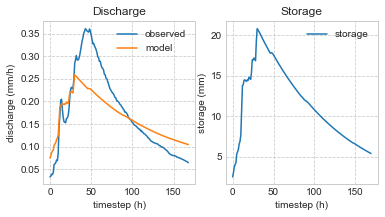

In [16]:
subplot(121)
plot(event_runoff,label='observed')
plot(runoff+groundwater_baseflow,label='model')
legend()
xlabel('timestep (h)')
ylabel('discharge (mm/h)')
title('Discharge')

subplot(122)
plot(storage,label='storage')
legend()
xlabel('timestep (h)')
ylabel('storage (mm)')
title('Storage')

# Direct runoff threshold

One might wish to allow for fast direct runoff at a certain threshold to account for a second sink in the linear reservoir.

In [17]:
#initialisation
l_event = len(event_precip)
storage = np.zeros(l_event+1)
runoff = np.zeros(l_event)
direct_runoff = np.zeros(l_event)

soilmoist = np.zeros(l_event+1)  #soil water storage
subsurf_flow = np.zeros(l_event) #flow from the soil

groundwater_store = np.zeros(l_event+1)  #groundwater storage
groundwater_perc = np.zeros(l_event)     #flow from the upper to the lower bucket of the cascade
groundwater_baseflow = np.zeros(l_event) #flow from groundwater storage

In [18]:
#Parameters
residence_t = 66. #mean residence time of water in storage (days)
ET = 0.125         #assumed evapotranspiration around 3mm/day
storage[0] = 2.5   #initial filling of storage

beta = 1.25        #beta store exponential parameter
smax = 0.3 * 1000  #Maximum storage as product of soil porosity and soil depth in mm
soilmoist[0] = 150 #initial soil storage

groundwater_store[0] = 500  #initial groundwater storage
residence_GW1 = 10000.      #residence time for GW recharge        
residence_GW2 = 100000.     #residence time for GW baseflow

direct_runoff_threshold = 5. #threshold to consider second sink to linear reservoir
residence_quick = 100.       #residence time of "upper part" of the reservoir

In [19]:
#Run model
for i in np.arange(l_event): #time step loop (1h)
    #beta store
    subsurf_flow[i] = event_precip[i] * (soilmoist[i]/smax)**beta
    soilmoist[i+1] = soilmoist[i] + event_precip[i] - subsurf_flow[i] - ET
    
    #direct runoff
    if storage[i]>direct_runoff_threshold:
        direct_runoff[i] = np.max([0.,storage[i]-direct_runoff_threshold])/residence_quick
    
    #linear storage
    runoff[i] = storage[i]/residence_t
    groundwater_perc[i] = storage[i]/residence_GW1
    storage[i+1] = storage[i] - runoff[i] - direct_runoff[i] - groundwater_perc[i] + subsurf_flow[i]
    
    #groundwater reservoir
    groundwater_baseflow[i] = groundwater_store[i]/residence_GW1
    groundwater_store[i+1] = groundwater_store[i] + groundwater_perc[i] #groundwater_baseflow[i] will go in and out, so we drop it here

Text(0.5,1,'Storage')

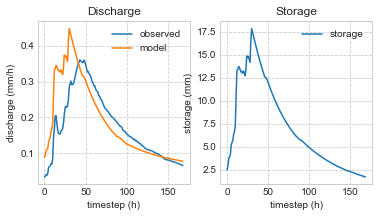

In [20]:
subplot(121)
plot(event_runoff,label='observed')
plot(runoff+direct_runoff+groundwater_baseflow,label='model')
legend()
xlabel('timestep (h)')
ylabel('discharge (mm/h)')
title('Discharge')

subplot(122)
plot(storage,label='storage')
legend()
xlabel('timestep (h)')
ylabel('storage (mm)')
title('Storage')

Our final model is basically the core of the HBV approach. You can now check how it performs for a different event or even a longer time series. For this you may like to define the model as a function as we did in tutorial 1 and 2...